In [ ]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim import Adam
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize

import torch.nn.functional as F

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset loading

In [ ]:
transform_func = Compose([
    ToTensor(),
    Normalize([0.5], [0.5])
])

In [ ]:
dataset = MNIST('data', train=True, download=True, transform=transform_func)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 479kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.41MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.83MB/s]


In [ ]:
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )

In [ ]:
train_loader = DataLoader(dataset, batch_size=128, shuffle=True)

In [ ]:
test_dataset = MNIST('data', train=False, download=True, transform=transform_func)

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [ ]:
img, label = dataset[0]

In [ ]:
img_shape = tuple(img.shape)

In [ ]:
class_num = 10

# Utils

## Evaluation Classifier

In [ ]:
class Eval_Classifier(nn.Module):
  def __init__(self, class_num=10):
    super(Eval_Classifier, self).__init__()

    self.class_num = class_num

    self.conv1 = nn.Conv2d(1, 28, 3, 1)
    self.conv2 = nn.Conv2d(28, 64, 3, 1)

    self.pool = nn.MaxPool2d(2, 2)

    self.dropout1 = nn.Dropout(0.3)
    self.dropout2 = nn.Dropout(0.5)

    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, class_num)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = self.pool(x)
    x = self.dropout1(x)

    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = self.dropout2(x)
    x = self.fc2(x)

    out = F.log_softmax(x, dim=1)
    return out

In [ ]:
def classifier_train(model, data_loader, optimizer, epochs, device):
  model.train()

  for epoch in range(epochs):
    for i, (img, label) in enumerate(data_loader):
      img, label = img.to(device), label.to(device)

      optimizer.zero_grad()

      output = model(img)
      loss = F.cross_entropy(output, label)
      loss.backward()
      optimizer.step()

      pred = output.argmax(dim=1)

      print(f'Epoch: {epoch+1} / {epochs} | Loss: {loss.item():.4f}')

In [ ]:
def classifier_test(model, data_loader, device):
  model.eval()
  total_loss = 0
  correct = 0

  with torch.no_grad():
    for img, label in data_loader:
      img, label = img.to(device), label.to(device)

      out = model(img)
      loss = F.cross_entropy(out, label)

      total_loss += loss.item()
      pred = out.argmax(dim=1)
      correct += pred.eq(label).sum().item()

  avg_loss = total_loss / len(data_loader)
  accuracy = 100. * correct / len(data_loader.dataset)
  print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

In [ ]:
classifier = Eval_Classifier().to(device)

In [ ]:
classifier_optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

In [ ]:
classifier_train(
    model=classifier,
    data_loader=train_loader,
    optimizer=classifier_optimizer,
    epochs=5,
    device=device
)

In [ ]:
classifier_test(
    model=classifier,
    data_loader=test_loader,
    device=device
)

Test Loss: 0.0355, Test Accuracy: 98.85%


## Train function

In [ ]:
def train(generator, discriminator, data_loader,
          optimizer_generator, optimizer_discriminator, criterion, device,
          latent_dim=100, epochs=5):
    for epoch in range(epochs):
        for i, (imgs, labels) in enumerate(data_loader):
            batch_size_curr = imgs.size(0)

            valid = torch.ones(batch_size_curr, 1).to(device)
            fake = torch.zeros(batch_size_curr, 1).to(device)

            real_imgs = imgs.to(device)

            optimizer_generator.zero_grad()

            z = torch.randn(batch_size_curr, latent_dim).to(device)
            gen_labels = torch.randint(0, 10, (batch_size_curr,), device=device)

            gen_imgs = generator(z, gen_labels)

            g_loss = criterion(discriminator(gen_imgs, gen_labels), valid)

            g_loss.backward()
            optimizer_generator.step()

            optimizer_discriminator.zero_grad()

            real_loss = criterion(discriminator(real_imgs, labels.to(device)), valid)
            fake_loss = criterion(discriminator(gen_imgs.detach(), gen_labels), fake)
            d_loss = 0.5 * (real_loss + fake_loss)
            d_loss.backward()
            optimizer_discriminator.step()

            print(f"Epoch {epoch + 1}/{epochs} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

        if (epoch + 1) % 5 == 0:
            sample_images(generator, device=device)

## Digit visualization

In [ ]:
def sample_images(generator, device):
    generator.eval()
    noise = torch.randn(1, 100).to(device)
    label = torch.tensor([7], device=device) # primer 7
    gen_img = generator(noise, label)
    gen_img = gen_img.view(1, 1, 28, 28)
    gen_img = gen_img * 0.5 + 0.5
    plt.imshow(gen_img[0].detach().cpu().squeeze().numpy())
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

def visualize_digits(generator, device, latent_dim=100):
    generator.eval()
    num_classes = 10
    noise = torch.randn(num_classes, latent_dim).to(device)
    labels = torch.arange(0, num_classes).to(device)
    with torch.no_grad():
        gen_imgs = generator(noise, labels)
    gen_imgs = gen_imgs * 0.5 + 0.5

    fig, axes = plt.subplots(1, 10, figsize=(15, 2))
    for i, ax in enumerate(axes):
        ax.imshow(gen_imgs[i].cpu().squeeze(), cmap='gray')
        ax.set_title(f"Digit: {i}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

## Eval function

In [ ]:
def eval(generator, classifier, latent_dim, num_classes, num_images, device):
  generator.eval()
  classifier.eval()

  correct = 0
  total = num_classes*num_images

  with torch.no_grad():
    for digit in range(num_classes):
       noise = torch.randn(num_images, latent_dim).to(device)
       labels = torch.full((num_images,), digit, dtype=torch.long).to(device)

       imgs = generator(noise, labels)

       out = classifier(imgs)
       pred = out.argmax(dim=1)

       correct += (pred == labels).sum().item()

    accuracy = correct / total
    print(f"Accuracy: {accuracy}")

# CGAN




In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape, class_num):
        super(Generator, self).__init__()

        self.label_embedding = nn.Embedding(class_num, class_num)

        self.model = nn.Sequential(
            nn.Linear(latent_dim + class_num, 128),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(128, momentum=0.8),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256, momentum=0.8),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512, momentum=0.8),
            nn.Linear(512, int(np.prod(img_shape))),
            nn.Tanh()
        )
        self.img_shape = img_shape

    def forward(self, noise, labels):
        input = torch.cat((self.label_embedding(labels), noise), -1)
        img = self.model(input)
        img = img.view(img.size(0), *self.img_shape)
        return img

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, img_shape, class_num):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(class_num, class_num)

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)) + class_num, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        input = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        out = self.model(input)
        return out


In [ ]:
generator = Generator(latent_dim=100, img_shape=img_shape, class_num=class_num).to(device)

In [ ]:
discriminator = Discriminator(img_shape=img_shape, class_num=class_num).to(device)

In [ ]:
optimizer_generator = Adam(generator.parameters(), lr=0.0002)

In [ ]:
optimizer_discriminator = Adam(discriminator.parameters(), lr=0.0002)

In [ ]:
criterion = nn.BCELoss()

In [ ]:
train(
    generator=generator,
    discriminator=discriminator,
    data_loader=train_loader,
    optimizer_generator=optimizer_generator,
    optimizer_discriminator=optimizer_discriminator,
    criterion=criterion,
    device=device,
    latent_dim=100,
    epochs=200
)

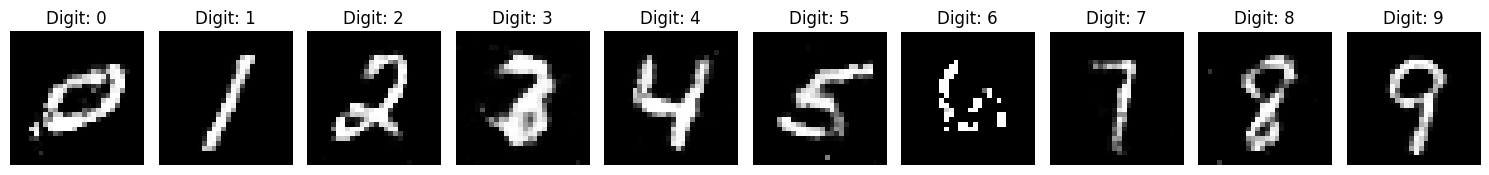

In [ ]:
visualize_digits(generator=generator, latent_dim=100, device=device)

## Eval

In [ ]:
eval(
    generator=generator,
    classifier=classifier,
    latent_dim=100,
    num_classes=10,
    num_images=100,
    device=device
)

Accuracy: 0.971


# DCGAN

In [ ]:
class DCGAN_Generator(nn.Module):

  def __init__(self,  latent_dim=100, img_shape=(1, 28, 28), class_num=10):
    super(DCGAN_Generator, self).__init__()

    self.label_embedding = nn.Embedding(class_num, class_num)

    self.model = nn.Sequential(
        nn.Linear(latent_dim+class_num, 128 * 7 * 7),
        nn.BatchNorm1d(128 * 7 * 7),
        nn.ReLU(True),
        nn.Unflatten(1, (128, 7, 7)),

        nn.ConvTranspose2d(128, 64, 4, 2, 1),
        nn.BatchNorm2d(64),
        nn.ReLU(True),

        nn.ConvTranspose2d(64, 1, 4, 2, 1),
        nn.Tanh()
    )

  def forward(self, noise, labels):
    input = torch.cat((noise, self.label_embedding(labels)), dim=1)
    out = self.model(input)
    return out

In [ ]:
class DCGAN_Discriminator(nn.Module):

  def __init__(self, img_shape=(1, 28, 28), class_num=10):
    super(DCGAN_Discriminator, self).__init__()

    self.img_shape = img_shape
    self.class_num = class_num

    self.label_embedding = nn.Embedding(class_num, class_num)

    self.model = nn.Sequential(
        nn.Conv2d(2, 64, 4, 2, 1),
        nn.LeakyReLU(0.2),

        nn.Conv2d(64, 128, 4, 2, 1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),

        nn.Flatten(),
        nn.Linear(128 * 7 * 7, 1),
        nn.Sigmoid()
    )

  def forward(self, img, labels):
    label_embed = self.label_embedding(labels).unsqueeze(2).unsqueeze(3)
    label_embed = label_embed.expand(labels.size(0), self.class_num, *self.img_shape[1:])

    x = torch.cat((img, label_embed[:, :1, :, :]), dim=1)
    out = self.model(x)
    return out

In [ ]:
dcgan_generator = DCGAN_Generator().to(device)

In [ ]:
dcgan_discriminator = DCGAN_Discriminator().to(device)

In [ ]:
dcgan_optimizer_generator = Adam(dcgan_generator.parameters(), lr=0.0002)

In [ ]:
dcgan_optimizer_discriminator = Adam(dcgan_discriminator.parameters(), lr=0.0002)

In [ ]:
criterion = nn.BCELoss()

In [ ]:
train(generator=dcgan_generator,
      discriminator=dcgan_discriminator,
      data_loader=train_loader,
      optimizer_generator=dcgan_optimizer_generator,
      optimizer_discriminator=dcgan_optimizer_discriminator,
      criterion=criterion,
      latent_dim=100,
      epochs=50,
      device=device)

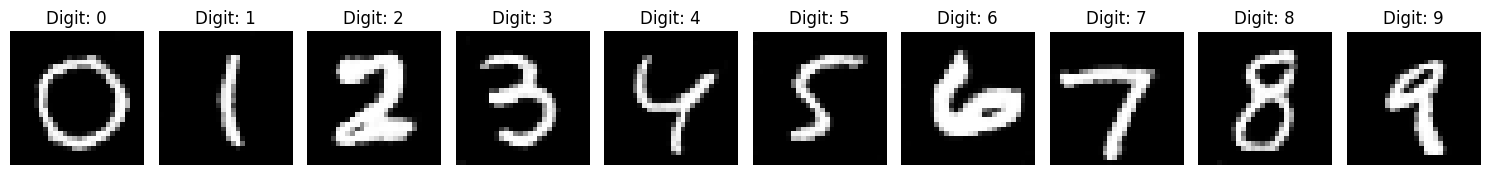

In [ ]:
visualize_digits(generator=dcgan_generator, latent_dim=100, device=device)

## Eval

In [ ]:
eval(
    generator=dcgan_generator,
    classifier=classifier,
    latent_dim=100,
    num_classes=10,
    num_images=100,
    device=device)

Accuracy: 0.992
